# Sentiment Analysis of the reviews

In [1]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm import tqdm
import nltk
import ssl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

ssl._create_default_https_context = ssl._create_unverified_context
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/khrystynamysak/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
analyzer = SentimentIntensityAnalyzer()

def sentiment_analyzer_scores(comment):
    score = analyzer.polarity_scores(comment)
    return (pd.DataFrame.from_dict(score, orient='index'))

reviews_path = "./reviews_dropna.csv"
reviews = pd.read_csv(reviews_path)
reviews.dropna(inplace=True)
# sentiment_analyzer_scores(reviews['comments'][0])

/var/folders/8b/hyq60bp52_9_w3t6s37pqbrr0000gn/T/ipykernel_33707/1855823683.py:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews = pd.read_csv(reviews_path)


In [27]:
tqdm.pandas(desc="Calculating Polarity")

def polarity_compound(s):
    return (analyzer.polarity_scores(s))['compound']

reviews['polarity'] = reviews['comments'].progress_apply(polarity_compound)

Calculating Polarity: 100%|██████████| 892839/892839 [06:13<00:00, 2388.74it/s]


In [29]:
reviews[:5].style.bar(subset=['polarity'], align='mid', color=['#d65f5f', '#5fba7d'])

,Unnamed: 0,listing_id,id,date,reviewer_id,reviewer_name,comments,polarity
0,0,2595.000000,17857.000000,2009-11-21,50679.000000,Jean,"Notre séjour de trois nuits. Nous avons apprécier L'appartement qui est très bien situé. Agréable, propre et bien soigné. C'est idéal pour une famille de 3 ou 4 personnes. Petits soucis en arrivant il y avait personne pour nous recevoir, et il manquait le savon pour la douche, le liquide vaisselle, nous les avons reçu de surlendemain. Il y a aussi le bruit du Métro de NY, donc une première nuit difficile si on est pas habitué. Jennifer est correcte le remboursement de la caution était très rapide. A part ces petits détails notre court séjour c'est bien passé. Si j'ai la possibilité de revenir sur NY pour les vacances, je reprendrai à ""The Midtown Castle"" Jean Possession - Ile de La Réunion",-0.361200
1,1,2595.000000,19176.000000,2009-12-05,53267.000000,Cate,Great experience.,0.624900
2,2,2595.000000,19760.000000,2009-12-10,38960.000000,Anita,"I've stayed with my friend at the Midtown Castle for six days and it was a lovely place to be. A big spacious room with a pointy roof, which really makes you feel like staying in a castle. The location is perfect. It is just a few steps from Macy's Time Square and Theatre District. Everything worked just perfect with the keys etc. Thank you so much Jennifer, we had a great time in New York. Attention: it's on the 4th floor without a lift :-) but definetely worth it!",0.924800
3,3,2595.000000,34320.000000,2010-04-09,71130.000000,Kai-Uwe,"We've been staying here for about 9 nights, enjoying to be in the center of the city, that never sleeps...short ways to everywhere in Manhattan, by subway or by walk. Midtown castle is a beauftiful and tastful place, Jennifer and Tori relaxed and friendly hosts - thats why we - the three Berliners - recommand that place! Good to have WiFi and a little kitchen too!",0.922900
4,4,2595.000000,46312.000000,2010-05-25,117113.000000,Alicia,We had a wonderful stay at Jennifer's charming apartment! They were very organized and helpful; I would definitely recommend staying at the Midtown Castle!,0.946400


In [28]:
reviews.to_csv("./NewYork/reviews_polared.csv")

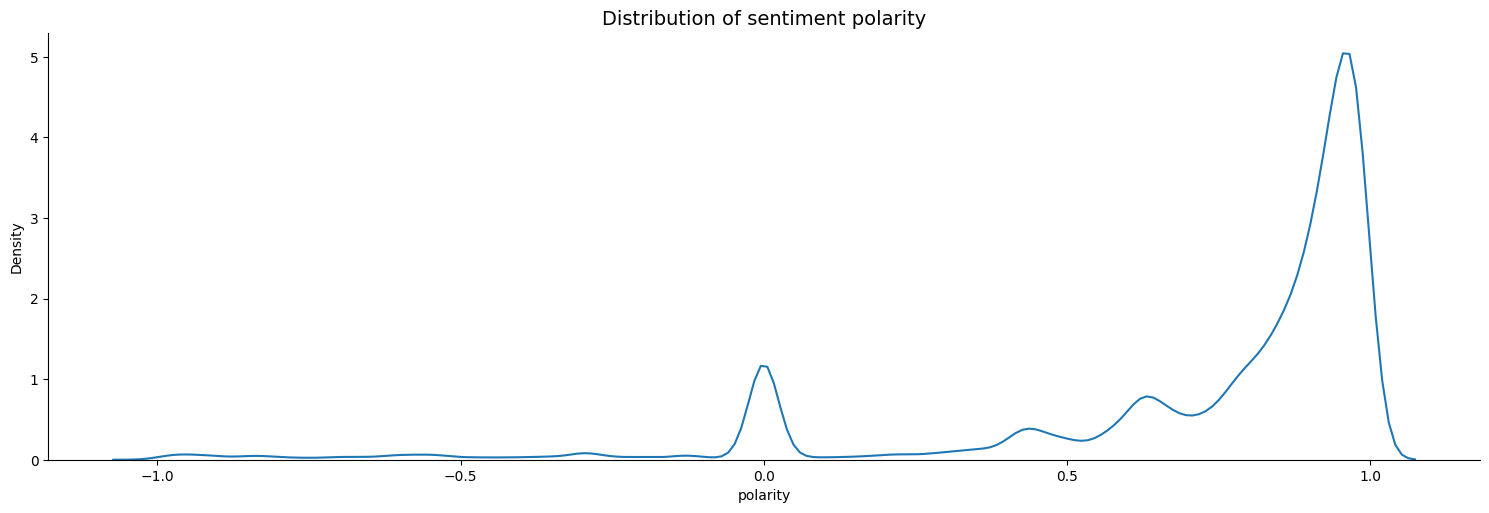

In [ ]:
sns.displot(
    reviews['polarity'], 
    kind="kde", 
    height=5,
    aspect=3   # (width = height * aspect)
)

plt.title('Distribution of sentiment polarity', fontsize=14)
plt.show()

# Examine correlation between review polarity and review scores

In [ ]:
listing = pd.read_csv("./NewYork/listings_cleaned.csv")
reviews = pd.read_csv("./NewYork/reviews_polared.csv")

In [52]:
listing.columns

Index(['id', 'listing_url', 'name', 'description', 'neighborhood_overview',
       'picture_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_verifications', 'neighbourhood_cleansed',
       'latitude', 'longitude', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'has_availability',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'license',
       'instant_bookable', 'calculated_host_listings_count',
       

In [53]:
reviews.columns

Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments',
       'polarity'],
      dtype='object')

In [ ]:
df_reviews_grouped = (
    reviews.groupby('listing_id')
    .agg({'comments': list})
    .reset_index()
)
sel_reviews = reviews[['listing_id', 'reviewer_id', 'polarity']]
sel_reviews['polarity'] = pd.to_numeric(sel_reviews['polarity'])

df_polarities_grouped = (
    sel_reviews.groupby(['listing_id'])
    .agg({'polarity': list})
    .reset_index()
)
# list_pol = pd.DataFrame(sel_reviews.groupby(['listing_id']).mean()['polarity']) --- for mean polarity
df_reviews_combined = pd.merge(df_polarities_grouped, df_reviews_grouped, on='listing_id')

/var/folders/8b/hyq60bp52_9_w3t6s37pqbrr0000gn/T/ipykernel_80987/598621129.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sel_reviews['polarity'] = pd.to_numeric(sel_reviews['polarity'])


In [4]:
df_reviews_grouped.head()

,listing_id,comments
0,2595.0,[Notre séjour de trois nuits.\r<br/>Nous avons...
1,5136.0,[My family had a wonderful stay at Rebecca and...
2,6848.0,[Stayed with Allen and Irina about a year ago....
3,6872.0,[This place is fantastic. Very clean and styli...
4,6990.0,"[Cynthia is very warm and welcoming, she does ..."


In [5]:
df_reviews_combined.head()

,listing_id,polarity,comments
0,2595.0,"[-0.3612, 0.6249, 0.9248, 0.9229, 0.9464, 0.98...",[Notre séjour de trois nuits.\r<br/>Nous avons...
1,5136.0,"[0.9965, 0.9833, 0.9682, 0.4932]",[My family had a wonderful stay at Rebecca and...
2,6848.0,"[0.923, 0.9562, 0.9637, 0.9756, 0.9679, 0.9991...",[Stayed with Allen and Irina about a year ago....
3,6872.0,[0.9817],[This place is fantastic. Very clean and styli...
4,6990.0,"[0.9655, 0.4215, 0.9904, 0.9864, 0.99, 0.9614,...","[Cynthia is very warm and welcoming, she does ..."


In [59]:
df_reviews_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22731 entries, 0 to 22730
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   listing_id  22731 non-null  float64
 1   polarity    22731 non-null  float64
 2   comments    22731 non-null  object 
dtypes: float64(2), object(1)
memory usage: 532.9+ KB


In [6]:
merged_df = pd.merge(listing, df_reviews_combined, left_on='id', right_on='listing_id', how='left')
merged_df = merged_df.drop(columns=['listing_id'])

In [7]:
merged_df.head()

,id,listing_url,name,description,neighborhood_overview,picture_url,host_name,host_since,host_location,host_about,...,review_scores_rating,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,polarity,comments
0,572612125615500056,https://www.airbnb.com/rooms/572612125615500056,Room by Sunny & Bay! Sunset Park & Bay Ridge,Cozy room in a charming Sunset Park apartment....,missing,https://a0.muscache.com/pictures/5f44a178-6043...,Joshua,2020-07-23,"New York, United States",missing,...,4.83,missing,t,2,0,2,0,0.21,"[0.8713, 0.6588, 0.9809, 0.8519, 0.5106, 0.6588]",[Friendly host! Very comfortable and quiet pla...
1,13234457,https://www.airbnb.com/rooms/13234457,Cozy Clinton Hill Crib On Classon,"My place is close to Barclays Center, Alice's ...",missing,https://a0.muscache.com/pictures/011da841-7234...,Letha M.,2008-09-10,"New York, NY",missing,...,4.00,missing,f,1,1,0,0,0.02,"[0.9625, 0.8814]",[Letha was a great hostess! She was easy to co...
2,773237631431486588,https://www.airbnb.com/rooms/773237631431486588,Home sweet home,Relax with the whole family at this peaceful p...,missing,https://a0.muscache.com/pictures/miso/Hosting-...,Myaa,2022-04-17,missing,missing,...,5.00,missing,f,1,0,1,0,0.06,[0.8779],"[myaa is a considerate host, easy to work with..."
3,1097125455525075775,https://www.airbnb.com/rooms/1097125455525075775,MCM-inspired with aged brass and soothing neut...,Our beautifully arranged classic twin guest ro...,missing,https://a0.muscache.com/pictures/prohost-api/H...,The Tillary Hotel Brooklyn,2024-02-20,missing,missing,...,4.26,Exempt,t,7,0,7,0,3.65,NaN,NaN
4,760086536368275287,https://www.airbnb.com/rooms/760086536368275287,Luxury apt in the best location of E. Williams...,The apt is brand new! Features floor to ceilin...,missing,https://a0.muscache.com/pictures/fa2ee030-aa77...,Luciana,2011-06-23,"New York, NY",Hi!! Ben and Lulu here! we are in tech and fas...,...,5.00,missing,f,1,1,0,0,0.37,"[0.9507, 0.8213, 0.9793, 0.9097, 0.9759, 0.784...",[Beautiful space! Pictures don’t do it Justice...


In [9]:
merged_df.dropna(inplace=True)
merged_df.isnull().sum()

id                                              0
listing_url                                     0
name                                            0
description                                     0
neighborhood_overview                           0
picture_url                                     0
host_name                                       0
host_since                                      0
host_location                                   0
host_about                                      0
host_response_time                              0
host_response_rate                              0
host_acceptance_rate                            0
host_is_superhost                               0
host_thumbnail_url                              0
host_picture_url                                0
host_neighbourhood                              0
host_verifications                              0
neighbourhood_cleansed                          0
latitude                                        0


In [10]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21506 entries, 0 to 22730
Data columns (total 48 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            21506 non-null  int64  
 1   listing_url                                   21506 non-null  object 
 2   name                                          21506 non-null  object 
 3   description                                   21506 non-null  object 
 4   neighborhood_overview                         21506 non-null  object 
 5   picture_url                                   21506 non-null  object 
 6   host_name                                     21506 non-null  object 
 7   host_since                                    21506 non-null  object 
 8   host_location                                 21506 non-null  object 
 9   host_about                                    21506 non-null  obje

In [12]:
merged_df.to_csv('./NewYork/merged_listings_reviews_polarities.csv', index=False)

In [11]:
merged_df.columns

Index(['id', 'listing_url', 'name', 'description', 'neighborhood_overview',
       'picture_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_verifications', 'neighbourhood_cleansed',
       'latitude', 'longitude', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'has_availability',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'first_review', 'last_review', 'review_scores_rating', 'license',
       'instant_bookable', 'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month',
    

# Correlation between polarity and ratings

In [ ]:
sel_reviews = reviews[['listing_id', 'reviewer_id', 'polarity']]

In [48]:
sel_listings = listing[['id', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 
                         'review_scores_cleanliness', 'review_scores_checkin', 
                         'review_scores_communication', 'review_scores_location', 'review_scores_value',
                         'neighbourhood_cleansed']]

In [31]:
sel_reviews.dtypes

listing_id     float64
reviewer_id    float64
polarity       float64
dtype: object

In [ ]:
sel_reviews['polarity'] = pd.to_numeric(sel_reviews['polarity'])
list_pol = pd.DataFrame(sel_reviews.groupby(['listing_id']).mean()['polarity'])

In [50]:
list_pol.head()

,polarity
listing_id,
2595.0,0.709088
5136.0,0.860300
6848.0,0.758508
6872.0,0.981700
6990.0,0.853382


In [33]:
# list_pol = pd.DataFrame(sel_reviews.groupby(['listing_id']).mean()['polarity'])
full = pd.merge(sel_listings, sel_reviews, left_on='id', right_on='listing_id', how='left')

In [34]:
full.head()

,id,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,neighbourhood_cleansed,listing_id,reviewer_id,polarity
0,572612125615500056,6,4.83,4.83,4.67,5.0,4.83,4.67,4.67,Sunset Park,5.726121e+17,213713628.0,0.8713
1,572612125615500056,6,4.83,4.83,4.67,5.0,4.83,4.67,4.67,Sunset Park,5.726121e+17,407939441.0,0.6588
2,572612125615500056,6,4.83,4.83,4.67,5.0,4.83,4.67,4.67,Sunset Park,5.726121e+17,337056945.0,0.9809
3,572612125615500056,6,4.83,4.83,4.67,5.0,4.83,4.67,4.67,Sunset Park,5.726121e+17,130825626.0,0.8519
4,572612125615500056,6,4.83,4.83,4.67,5.0,4.83,4.67,4.67,Sunset Park,5.726121e+17,48550051.0,0.5106


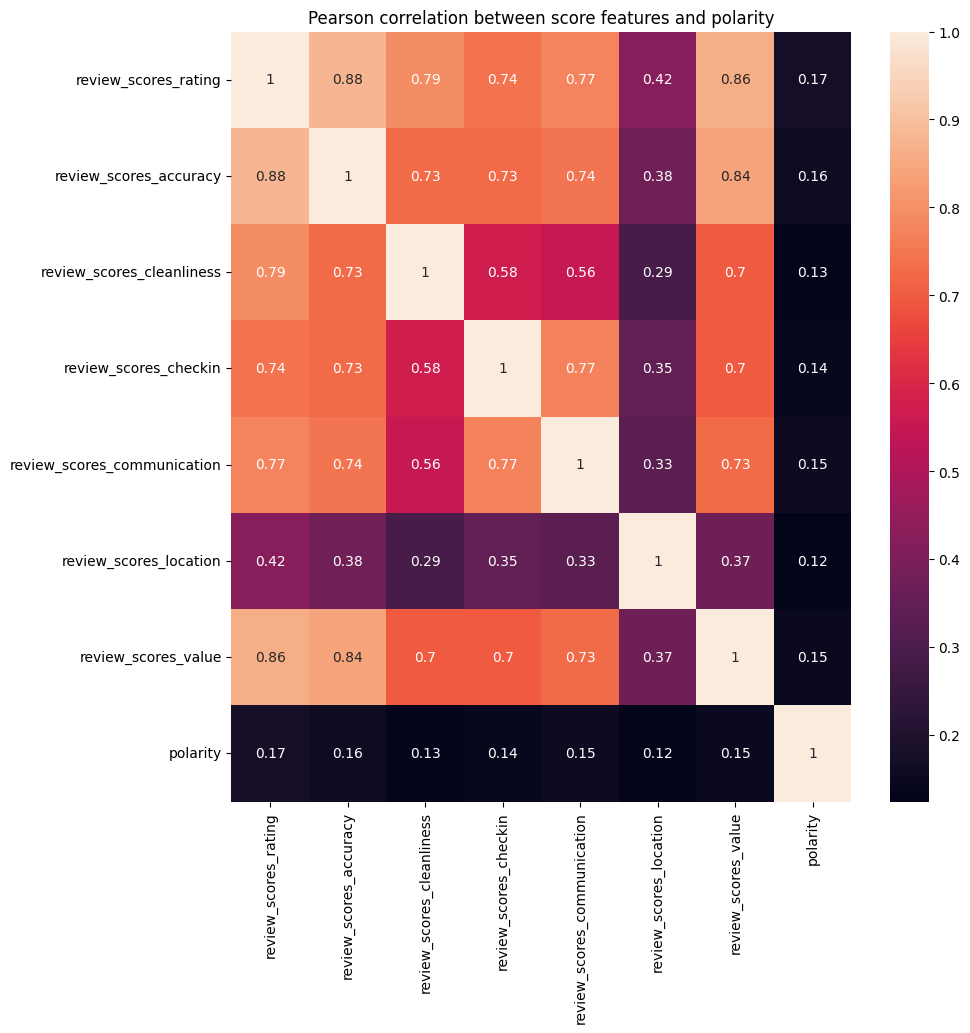

In [35]:
review_scores = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 
                 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
                 'review_scores_value', 'polarity']

corr = full[review_scores].corr()

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, annot=True)
plt.title('Pearson correlation between score features and polarity')
plt.show()

In [13]:
merged_img = pd.read_csv('./NewYork/merged_img_vectors.csv')
merged_polarities = pd.read_csv('./NewYork/merged_listings_reviews_polarities.csv')

In [15]:
merged_img.columns

Index(['id', 'listing_url', 'name', 'description', 'neighborhood_overview',
       'picture_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_verifications', 'neighbourhood_cleansed',
       'latitude', 'longitude', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'has_availability',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'license',
       'instant_bookable', 'calculated_host_listings_count',
       

In [18]:
merged_result = merged_polarities.merge(merged_img[['id', 'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'photo_vector']], on='id', how='left')

In [21]:
merged_img.head()

,id,listing_url,name,description,neighborhood_overview,picture_url,host_name,host_since,host_location,host_about,...,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,polarity,comments,photo_vector
0,572612125615500056,https://www.airbnb.com/rooms/572612125615500056,Room by Sunny & Bay! Sunset Park & Bay Ridge,Cozy room in a charming Sunset Park apartment....,missing,https://a0.muscache.com/pictures/5f44a178-6043...,Joshua,2020-07-23,"New York, United States",missing,...,missing,t,2,0,2,0,0.21,0.755383,['Friendly host! Very comfortable and quiet pl...,[0.99579644 0.05453015 0.00740186 0.01827555 0...
1,13234457,https://www.airbnb.com/rooms/13234457,Cozy Clinton Hill Crib On Classon,"My place is close to Barclays Center, Alice's ...",missing,https://a0.muscache.com/pictures/011da841-7234...,Letha M.,2008-09-10,"New York, NY",missing,...,missing,f,1,1,0,0,0.02,0.921950,"[""Letha was a great hostess! She was easy to c...",[0.9773287 0.05888927 0.05584503 0.09381795 0...
2,773237631431486588,https://www.airbnb.com/rooms/773237631431486588,Home sweet home,Relax with the whole family at this peaceful p...,missing,https://a0.muscache.com/pictures/miso/Hosting-...,Myaa,2022-04-17,missing,missing,...,missing,f,1,0,1,0,0.06,0.877900,"['myaa is a considerate host, easy to work wit...",[9.9997962e-01 5.6140092e-03 3.2629957e-04 6.4...
3,760086536368275287,https://www.airbnb.com/rooms/760086536368275287,Luxury apt in the best location of E. Williams...,The apt is brand new! Features floor to ceilin...,missing,https://a0.muscache.com/pictures/fa2ee030-aa77...,Luciana,2011-06-23,"New York, NY",Hi!! Ben and Lulu here! we are in tech and fas...,...,missing,f,1,1,0,0,0.37,0.918475,['Beautiful space! Pictures don’t do it Justic...,[0.9365714 0.01271252 0.00432584 0.03421113 0...
4,27883,https://www.airbnb.com/rooms/27883,East Village Sanctuary,"Sorry, this listing is no longer available.",missing,https://a0.muscache.com/pictures/2125269/6f827...,Jen,2010-05-07,"Maine, United States",Creative guru of media and fine art and good c...,...,missing,f,1,1,0,0,0.15,0.860724,"[""Jennifer was great to really work around our...",[4.4169790e-01 1.9763875e-01 3.6817792e-04 5.7...


In [19]:
merged_result.head()

,id,listing_url,name,description,neighborhood_overview,picture_url,host_name,host_since,host_location,host_about,...,reviews_per_month,polarity,comments,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,photo_vector
0,572612125615500056,https://www.airbnb.com/rooms/572612125615500056,Room by Sunny & Bay! Sunset Park & Bay Ridge,Cozy room in a charming Sunset Park apartment....,missing,https://a0.muscache.com/pictures/5f44a178-6043...,Joshua,2020-07-23,"New York, United States",missing,...,0.21,"[0.8713, 0.6588, 0.9809, 0.8519, 0.5106, 0.6588]",['Friendly host! Very comfortable and quiet pl...,4.83,4.67,5.0,4.83,4.67,4.67,[0.99579644 0.05453015 0.00740186 0.01827555 0...
1,13234457,https://www.airbnb.com/rooms/13234457,Cozy Clinton Hill Crib On Classon,"My place is close to Barclays Center, Alice's ...",missing,https://a0.muscache.com/pictures/011da841-7234...,Letha M.,2008-09-10,"New York, NY",missing,...,0.02,"[0.9625, 0.8814]","[""Letha was a great hostess! She was easy to c...",5.00,3.00,5.0,2.00,5.00,5.00,[0.9773287 0.05888927 0.05584503 0.09381795 0...
2,773237631431486588,https://www.airbnb.com/rooms/773237631431486588,Home sweet home,Relax with the whole family at this peaceful p...,missing,https://a0.muscache.com/pictures/miso/Hosting-...,Myaa,2022-04-17,missing,missing,...,0.06,[0.8779],"['myaa is a considerate host, easy to work wit...",5.00,5.00,5.0,5.00,4.00,5.00,[9.9997962e-01 5.6140092e-03 3.2629957e-04 6.4...
3,760086536368275287,https://www.airbnb.com/rooms/760086536368275287,Luxury apt in the best location of E. Williams...,The apt is brand new! Features floor to ceilin...,missing,https://a0.muscache.com/pictures/fa2ee030-aa77...,Luciana,2011-06-23,"New York, NY",Hi!! Ben and Lulu here! we are in tech and fas...,...,0.37,"[0.9507, 0.8213, 0.9793, 0.9097, 0.9759, 0.784...",['Beautiful space! Pictures don’t do it Justic...,5.00,5.00,5.0,5.00,5.00,5.00,[0.9365714 0.01271252 0.00432584 0.03421113 0...
4,27883,https://www.airbnb.com/rooms/27883,East Village Sanctuary,"Sorry, this listing is no longer available.",missing,https://a0.muscache.com/pictures/2125269/6f827...,Jen,2010-05-07,"Maine, United States",Creative guru of media and fine art and good c...,...,0.15,"[0.8976, 0.9184, 0.9775, 0.902, 0.93, 0.9432, ...","[""Jennifer was great to really work around our...",4.63,4.79,5.0,4.89,4.79,4.74,[4.4169790e-01 1.9763875e-01 3.6817792e-04 5.7...


In [22]:
merged_result.to_csv('./NewYork/full_merged.csv', index=False)